Initial Clustering:
We are basically clustering three values (elevation in meters, aspect in degrees, and slope in degrees). The salamanders live on north- and northwest-facing talus slopes and in hardwood forests above 2,870 feet. They prefer the cool, moist conditions found at higher elevations, where the mountaintops are often covered in fog.

Clustering might help us see which combination of these factors correspond to Salmander population density. We need to combine multiple datasets with this, but this is a start.

Dataset I used was: k_means_clusetering_dataset.csv

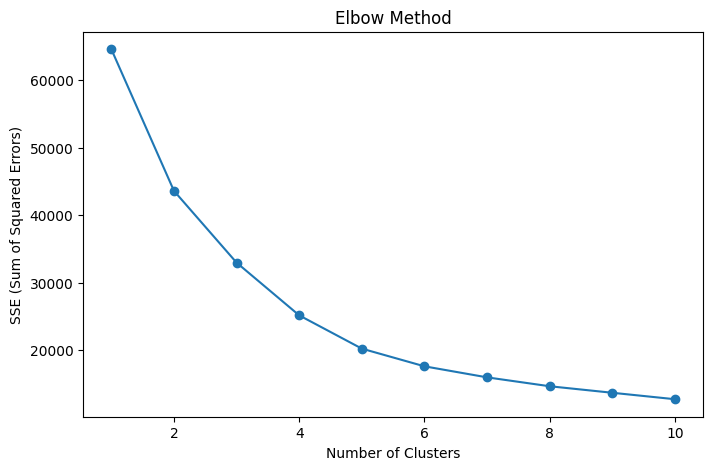

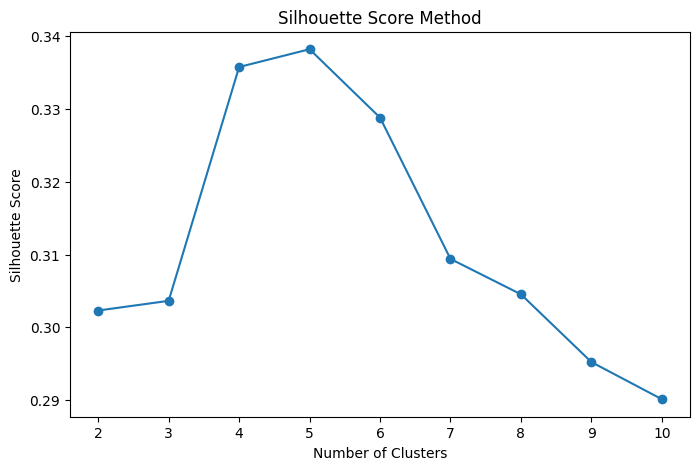

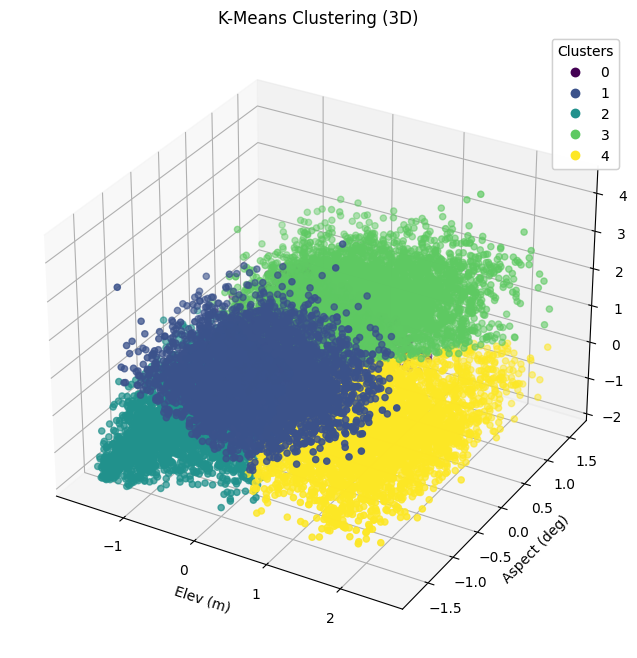

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Step 1: Load the dataset
data = pd.read_csv('kmeans_clustering_dataset.csv')

# Step 2: Handle missing values (if any)
data = data.dropna()

# Step 3: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 4: Elbow Method to determine the optimal number of clusters
def plot_elbow_method(data, max_clusters=10):
    sse = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters+1), sse, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.show()

plot_elbow_method(scaled_data)

# Step 5: Silhouette Score to further assess the optimal number of clusters
def calculate_silhouette_scores(data, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    plt.title('Silhouette Score Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

calculate_silhouette_scores(scaled_data)

# Step 6: Apply K-Means with the optimal number of clusters
optimal_k = 5  # Based on elbow or silhouette score analysis, adjust this as needed
kmeans = KMeans(n_clusters= optimal_k, random_state=42)
labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataset
data['Cluster'] = labels

# Step 7: Visualize the Clusters
def plot_clusters_3d(data, labels):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='viridis', marker='o')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    ax.set_xlabel('Elev (m)')
    ax.set_ylabel('Aspect (deg)')
    ax.set_zlabel('Slope (deg)')
    plt.title('K-Means Clustering (3D)')
    plt.show()

plot_clusters_3d(scaled_data, labels)

# Save the results
data.to_csv('kmeans_clustering_results.csv', index=False)


Using the data_by_trasenct_v2.csv file, I predicted pshen, which is the number of salamanders, based on features. This is a regression based project. I used random forest regressor and a decision tree regressor to do this and 5 fold cv with negative mean squared error. I found the optimized hyperparameters with a grid search.

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = 'data_by_transect_v2.csv'
data = pd.read_csv(file_path)

# Step 1: Handle missing values and preprocess the data
# Identify the target column and features
target = 'pshen'
features = ['pcin', 'Cover', 'temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)', 'moss']

# Separate the target and features
X = data[features]
y = data[target]

# Handle missing values and categorical columns
numeric_features = ['pcin', 'Cover', 'temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)', 'moss']
categorical_features = []

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 2: Define the models
random_forest = RandomForestRegressor(random_state=42)
decision_tree = DecisionTreeRegressor(random_state=42)

# Step 3: Define hyperparameter grids for both models
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

param_grid_dt = {
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Step 4: Set up pipelines for both models
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', random_forest)])

pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', decision_tree)])

# Step 5: Perform Grid Search with 5-fold CV for both models
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Step 6: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the models
grid_search_rf.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)

# Step 7: Get the best parameters and scores for both models
best_rf = grid_search_rf.best_estimator_
best_dt = grid_search_dt.best_estimator_

print("Best parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best parameters for Decision Tree: ", grid_search_dt.best_params_)

# Step 8: Evaluate both models using 5-fold CV
cv_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_dt = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print(f'Random Forest 5-fold CV Mean MSE: {-cv_scores_rf.mean()}')
print(f'Decision Tree 5-fold CV Mean MSE: {-cv_scores_dt.mean()}')

# Step 9: Evaluate on the test set
y_pred_rf = best_rf.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_dt = mean_squared_error(y_test, y_pred_dt)

print(f'Random Forest Test MSE: {mse_rf}')
print(f'Decision Tree Test MSE: {mse_dt}')


Best parameters for Random Forest:  {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best parameters for Decision Tree:  {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5}
Random Forest 5-fold CV Mean MSE: 3.5200651360079513
Decision Tree 5-fold CV Mean MSE: 4.151426542877582
Random Forest Test MSE: 3.1465405416842205
Decision Tree Test MSE: 3.630911844156926


Doing the same thing with a neural network, just playing around and seeing what works. Also trying to visualize it. Lol

  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=66a76495c5f9248b3af86944fb4e410a3e1c308f1e6b8f027e8c9a1581b854de
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


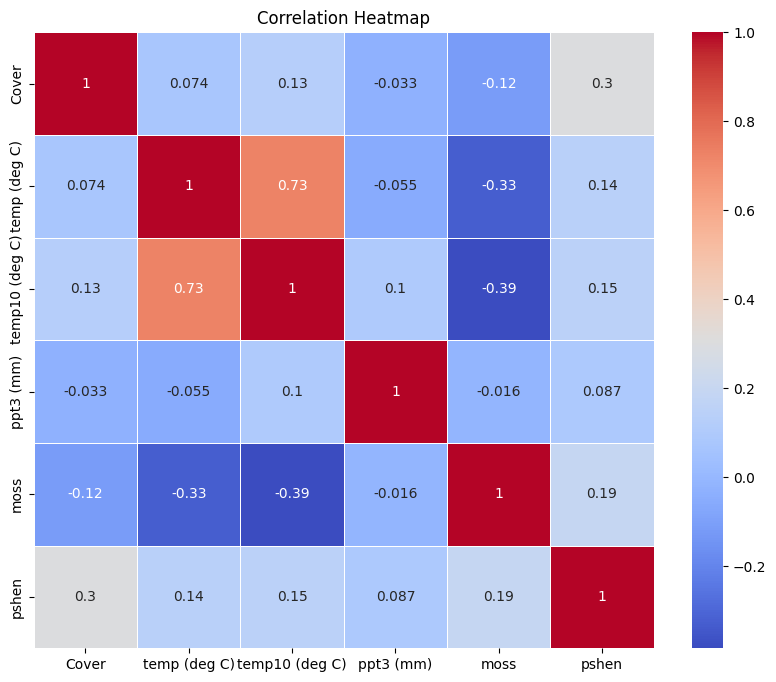

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 26.5637 - val_loss: 22.0805
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 22.5209 - val_loss: 18.2128
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18.9019 - val_loss: 15.0712
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.3615 - val_loss: 13.8786
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.8096 - val_loss: 11.2239
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.1752 - val_loss: 9.9927
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.3954 - val_loss: 9.6041
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.6513 - val_loss: 9.7260
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.0817 - val_loss: 8.6333
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4280 - val_loss: 11.8085
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.6570 - val_loss: 8.4345
Epoch 12/50
287/287 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


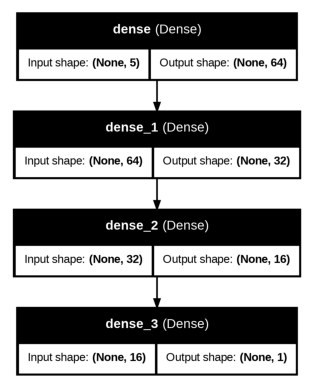

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
!pip install ann_visualizer
from ann_visualizer.visualize import ann_viz

# Neural Network Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_by_transect_v2.csv'
data = pd.read_csv(file_path)

# Step 1: Identify the target column and features
target = 'pshen'
features = ['Cover', 'temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)', 'moss']

# Separate the target and features
X = data[features]
y = data[target]

# Step 2: Handle missing values and categorical columns
numeric_features = ['Cover', 'temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)', 'moss']
categorical_features = []

correlation_data = data[numeric_features + [target]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Step 4: Scale the data for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define a neural network architecture
model = Sequential()

# Input layer (number of features = number of columns in X_train)
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer (for regression tasks, just 1 output)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the neural network
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, batch_size=32, verbose=1)

# Step 7: Evaluate the model on the test set
y_pred_nn = model.predict(X_test_scaled)

# Step 8: Calculate regression metrics for the neural network
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# Print the results for the neural network
print(f'Neural Network Test MSE: {mse_nn}')
print(f'Neural Network Test RMSE: {rmse_nn}')
print(f'Neural Network Test MAE: {mae_nn}')
print(f'Neural Network R²: {r2_nn}')

# Step 9: Visualize the neural network architecture
plot_model(model, to_file='neural_network.png', show_shapes=True, show_layer_names=True)

# Display the plot
img = plt.imread('neural_network.png')
plt.imshow(img)
plt.axis('off')
plt.show()

#ann_viz(model, title= "Salamander Neural Network")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 21.2570 - val_loss: 12.2700
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 11.4843 - val_loss: 9.6424
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.3597 - val_loss: 8.8793
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.3903 - val_loss: 8.2683
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.6366 - val_loss: 7.9661
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.9802 - val_loss: 7.2174
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.3535 - val_loss: 7.7503
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.0700 - val_loss: 6.7128
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.9148 - val_loss: 6.6423
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.2227 - val_loss: 6.2392
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.6017 - val_loss: 6.3589
Epoch 12/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 9m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Neural Network Test MSE: 5.024664556710148
Neural Network Test RMSE: 2.24157635531564
Neural Network Test MAE: 1.0383819758736095
Neural Network R²: 0.8171676993370056


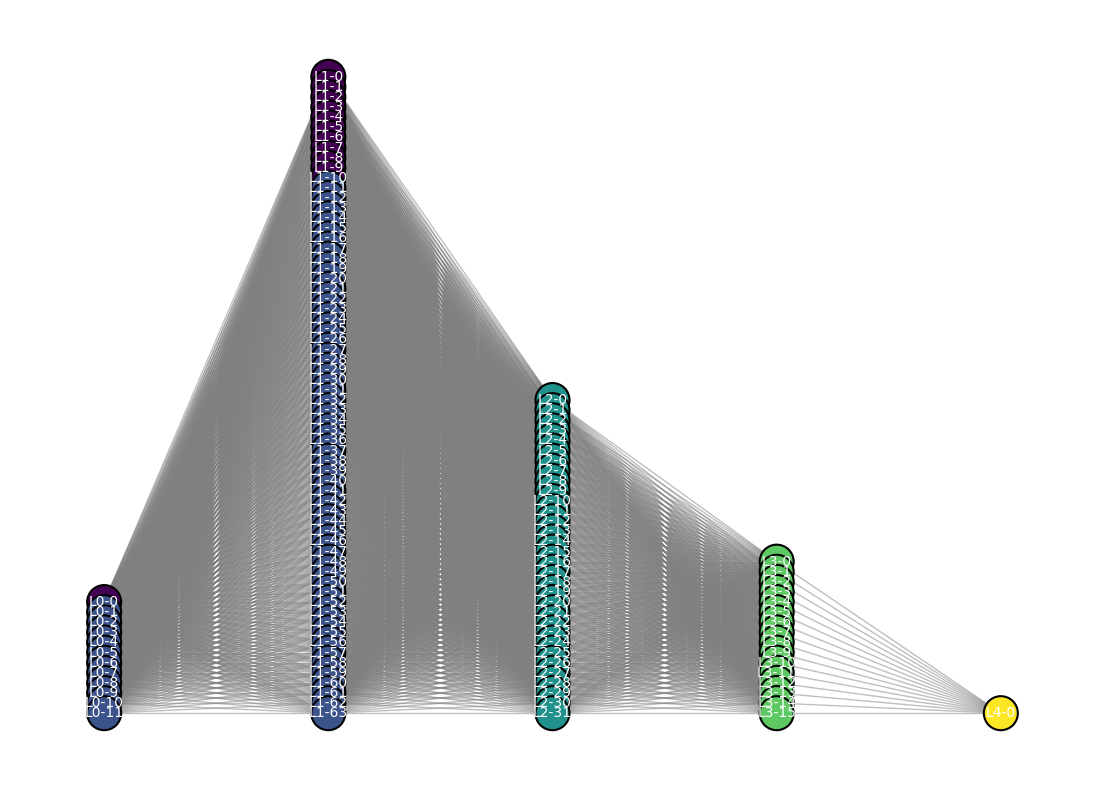

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import networkx as nx

# Load the dataset
file_path = 'data_by_transect_v2.csv'
data = pd.read_csv(file_path)

# Step 1: Identify the target column and features
target = 'pshen'
features = ['Cover', 'temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)', 'moss']

# Separate the target and features
X = data[features]
y = data[target]

# Step 2: Handle missing values and categorical columns
numeric_features = ['Cover', 'temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)', 'moss']
categorical_features = []

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Step 4: Scale the data for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define a neural network architecture
model = Sequential()

# Input layer (number of features = number of columns in X_train)
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer (for regression tasks, just 1 output)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the neural network
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, batch_size=32, verbose=1)

# Step 7: Evaluate the model on the test set
y_pred_nn = model.predict(X_test_scaled)

# Step 8: Calculate regression metrics for the neural network
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# Print the results for the neural network
print(f'Neural Network Test MSE: {mse_nn}')
print(f'Neural Network Test RMSE: {rmse_nn}')
print(f'Neural Network Test MAE: {mae_nn}')
print(f'Neural Network R²: {r2_nn}')

import matplotlib.pyplot as plt
import networkx as nx

def create_neural_network_graph(layer_sizes):
    """
    Create a networkx graph representing a neural network.

    :param layer_sizes: List containing the number of nodes in each layer.
    :return: A networkx graph object with nodes and edges representing the network.
    """
    G = nx.Graph()

    # Positioning the nodes in layers
    pos = {}
    node_count = 0

    for i, size in enumerate(layer_sizes):
        # Distribute nodes vertically in each layer
        for j in range(size):
            pos[node_count] = (i, size - j - 1)  # (x, y) position for each node
            node_count += 1

    # Add edges between consecutive layers
    node_idx = 0
    for l in range(len(layer_sizes) - 1):
        for i in range(layer_sizes[l]):
            for j in range(layer_sizes[l + 1]):
                G.add_edge(node_idx + i, node_idx + layer_sizes[l] + j)
        node_idx += layer_sizes[l]

    return G, pos



def create_neural_network_graph(layer_sizes):
    """
    Create a networkx graph representing a neural network.

    :param layer_sizes: List containing the number of nodes in each layer.
    :return: A networkx graph object with nodes and edges representing the network.
    """
    G = nx.Graph()

    # Positioning the nodes in layers
    pos = {}
    node_count = 0

    for i, size in enumerate(layer_sizes):
        # Distribute nodes vertically in each layer
        for j in range(size):
            pos[node_count] = (i, size - j - 1)  # (x, y) position for each node
            node_count += 1

    # Add edges between consecutive layers
    node_idx = 0
    for l in range(len(layer_sizes) - 1):
        for i in range(layer_sizes[l]):
            for j in range(layer_sizes[l + 1]):
                G.add_edge(node_idx + i, node_idx + layer_sizes[l] + j)
        node_idx += layer_sizes[l]

    return G, pos

def draw_neural_network_graph(G, pos, layer_sizes):
    """
    Draw the neural network graph using networkx and matplotlib.

    :param G: A networkx graph object.
    :param pos: Dictionary containing node positions.
    :param layer_sizes: List of number of nodes in each layer.
    """
    plt.figure(figsize=(14, 10))
    ax = plt.gca()
    ax.axis('off')

    # Draw nodes with different colors for each layer
    node_color = []
    node_idx = 0
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_sizes)))  # Layer-wise color map

    for i, size in enumerate(layer_sizes):
        node_color.extend([colors[i]] * size)
        node_idx += size

    nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_color, edgecolors='black', linewidths=1.5)

    # Draw edges with transparency for better visuals
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')

    # Add labels to nodes
    labels = {}
    node_idx = 0

    for l, size in enumerate(layer_sizes):
        for i in range(size):
            labels[node_idx] = f'L{l}-{i}'  # Label in format "L{layer}-{node}"
            node_idx += 1

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='white')

    plt.show()

# Define the Neural Network Layer Sizes
layer_sizes = [X_train_scaled.shape[1], 64, 32, 16, 1]  # Input layer, two hidden layers, and output layer

# Create the graph and position dictionary
G, pos = create_neural_network_graph(layer_sizes)

# Draw the graph
draw_neural_network_graph(G, pos, layer_sizes)



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import plotly.graph_objects as go
import networkx as nx
import numpy as np

# Load the dataset
file_path = 'data_by_transect_v2.csv'
data = pd.read_csv(file_path)

# Step 1: Identify the target column and features
target = 'pshen'
features = ['Cover', 'temp (deg C)', 'temp10 (deg C)',
            'ppt3 (mm)', 'moss']

# Separate target and features
X = data[features]
y = data[target]

# Step 2: Handle missing values and categorical columns
numeric_features = ['pcin', 'Cover', 'temp (deg C)',
                    'temp10 (deg C)', 'ppt3 (mm)', 'moss']
categorical_features = []

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_preprocessed = preprocessor.fit_transform(X)

# Step 3: Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define and train the neural network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1)

# Function to create a graph for the neural network
def create_neural_network_graph(layer_sizes):
    G = nx.DiGraph()
    node_positions = {}
    node_count = 0

    # Add nodes and edges
    for i, size in enumerate(layer_sizes):
        for j in range(size):
            node_positions[node_count] = (i, size - j - 1)
            G.add_node(node_count, layer=i)
            node_count += 1

    # Add edges between consecutive layers
    node_idx = 0
    for l in range(len(layer_sizes) - 1):
        for i in range(layer_sizes[l]):
            for j in range(layer_sizes[l + 1]):
                G.add_edge(node_idx + i, node_idx + layer_sizes[l] + j, weight=np.random.rand())
        node_idx += layer_sizes[l]

    return G, node_positions

# Create the graph and positions
layer_sizes = [X_train_scaled.shape[1], 64, 32, 16, 1]
G, pos = create_neural_network_graph(layer_sizes)

# Function to plot the graph interactively using Plotly
def plot_interactive_graph(G, pos):
    edge_x = []
    edge_y = []
    edge_weights = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(edge[2]['weight'])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    node_x = []
    node_y = []
    node_text = []

    for node, (x, y) in pos.items():
        node_x.append(x)
        node_y.append(y)
        layer = G.nodes[node]['layer']
        node_text.append(f'Node {node}<br>Layer {layer}')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        marker=dict(
            size=10,
            color=[G.nodes[n]['layer'] for n in G.nodes()],
            colorscale='Viridis',
            line_width=2
        ),
        text=node_text,
        hoverinfo='text'
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Neural Network Diagram',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    fig.show()

# Plot the interactive neural network graph
plot_interactive_graph(G, pos)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 25.8137
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 14.9798
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11.7993
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.3457
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 9.7298
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 8.8070
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 8.5173
Epoch 8/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.5000
Epoch 9/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.0240
Epoch 10/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.0284


We are now going to predict using classification. Based on various factors we are going to predict the prescence of Salamanders in the region. We are going to be using a Random Forest classifier and other models we talked about in class.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CentroidID      383 non-null    int64  
 1   pshen_total     383 non-null    int64  
 2   temp (deg C)    349 non-null    float64
 3   temp10 (deg C)  349 non-null    float64
 4   elevation (m)   383 non-null    float64
 5   aspect (deg)    383 non-null    float64
 6   slope (deg)     383 non-null    float64
 7   ppt3 (mm)       349 non-null    float64
 8   present         383 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 27.1 KB
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        61
           1       0.90      0.81      0.85        54

    accuracy                           0.87       115
   macro avg       0.87      0.87      0.87       115
weighted avg       0.87      0.87      0.87       115



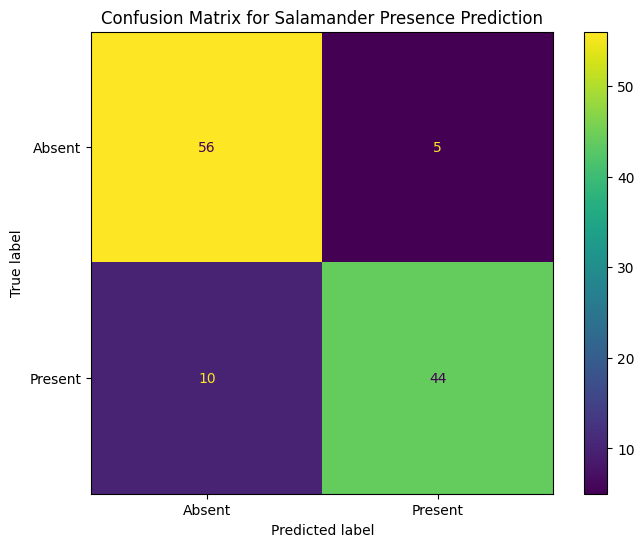

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('prediction_data_new.csv')

# Display dataset info and the first few rows
data.info()
data.head()

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
data_imputed = data.copy()
data_imputed[['temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)']] = imputer.fit_transform(
    data[['temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)']]
)

# Separate features and target variable
X = data_imputed.drop(['CentroidID', 'present', 'pshen_total'], axis=1)  # Drop irrelevant and target columns
y = data_imputed['present']

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate classification report and confusion matrix
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Absent', 'Present'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.title('Confusion Matrix for Salamander Presence Prediction')
plt.show()



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        61
           1       0.90      0.81      0.85        54

    accuracy                           0.87       115
   macro avg       0.87      0.87      0.87       115
weighted avg       0.87      0.87      0.87       115


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        61
           1       0.78      0.74      0.76        54

    accuracy                           0.78       115
   macro avg       0.78      0.78      0.78       115
weighted avg       0.78      0.78      0.78       115


SVM (RBF Kernel) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        61
           1       0.79      0.83      0.81        54

    accuracy                           0.82       115
   ma

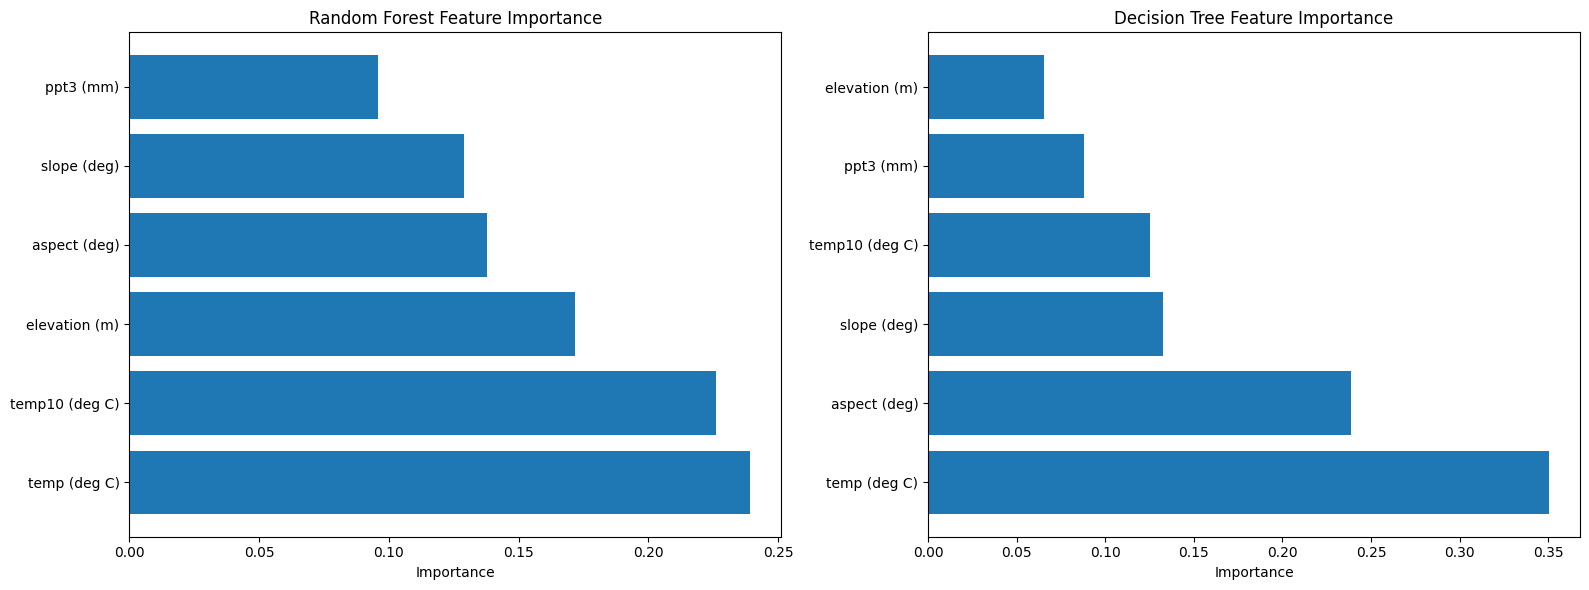

Model Performance Comparison:
Random Forest: 0.87
Logistic Regression: 0.78
SVM (RBF Kernel): 0.82
K-Nearest Neighbors: 0.80
Decision Tree: 0.78


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('prediction_data_new.csv')

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
data_imputed = data.copy()
data_imputed[['temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)']] = imputer.fit_transform(
    data[['temp (deg C)', 'temp10 (deg C)', 'ppt3 (mm)']]
)

# Separate features and target variable
X = data_imputed.drop(['CentroidID', 'present', 'pshen_total'], axis=1)  # Drop irrelevant and target columns
y = data_imputed['present']

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define multiple models for comparison
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

# Store model performances
model_performance = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    model_performance[name] = accuracy

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Plot feature importance for Random Forest and Decision Tree models
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
rf_model = models["Random Forest"]
importances_rf = rf_model.feature_importances_
indices_rf = importances_rf.argsort()[::-1]
feature_names_rf = X.columns[indices_rf]
axs[0].barh(feature_names_rf, importances_rf[indices_rf])
axs[0].set_title("Random Forest Feature Importance")
axs[0].set_xlabel("Importance")

# Decision Tree Feature Importance
dt_model = models["Decision Tree"]
importances_dt = dt_model.feature_importances_
indices_dt = importances_dt.argsort()[::-1]
feature_names_dt = X.columns[indices_dt]
axs[1].barh(feature_names_dt, importances_dt[indices_dt])
axs[1].set_title("Decision Tree Feature Importance")
axs[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

# Display model performance comparison
print("Model Performance Comparison:")
for name, accuracy in model_performance.items():
    print(f"{name}: {accuracy:.2f}")


Ok, we saved the random forest, model, and we are running it to make new predictions, (predicted_present (0 if no 1 if yes))

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load the training dataset
train_data = pd.read_csv('prediction_data_new.csv')

# Define feature columns and target based on the training dataset
feature_columns = ['elevation (m)', 'slope (deg)', 'aspect (deg)', 'ppt3 (mm)', 'temp10 (deg C)', 'temp (deg C)']
X_train = train_data[feature_columns]
y_train = train_data['present']  # Assuming 'present' is the target column in your training data

# Impute missing values in training data if any
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Scale features in training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Split the training data into train and test sets for evaluation (e.g., 70% train, 30% test)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42)

# Train the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_split, y_train_split)

# Save the trained model
joblib.dump(random_forest_model, 'random_forest_model.joblib')

# Evaluate model on the test split of the training dataset
y_test_pred = random_forest_model.predict(X_test_split)
accuracy = accuracy_score(y_test_split, y_test_pred)
conf_matrix = confusion_matrix(y_test_split, y_test_pred)
class_report = classification_report(y_test_split, y_test_pred)

# Display metrics
print(f"Accuracy on test split: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Load the new dataset for prediction
new_data = pd.read_csv('new_land_data.csv')  # Update path as needed
X_new = new_data[feature_columns]

# Impute missing values in new data
X_new_imputed = imputer.transform(X_new)

# Scale features in new data
X_new_scaled = scaler.transform(X_new_imputed)

# Predict on new data
predictions = random_forest_model.predict(X_new_scaled)

# Add predictions to the dataframe
new_data_with_predictions = new_data.copy()
new_data_with_predictions['predicted_present'] = predictions
print(new_data_with_predictions)

# Save predictions to a CSV file
new_data_with_predictions.to_csv('new_data_with_predictions.csv', index=False)
print("Predictions saved to 'new_data_with_predictions.csv'")


Accuracy on test split: 0.84

Confusion Matrix:
 [[54  7]
 [11 43]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        61
           1       0.86      0.80      0.83        54

    accuracy                           0.84       115
   macro avg       0.85      0.84      0.84       115
weighted avg       0.84      0.84      0.84       115

       fid    id  left   top  right  bottom  row_index  col_index  \
0       12    12 -85.0  39.9  -84.9    40.0         11          0   
1       13    13 -85.0  39.8  -84.9    39.9         12          0   
2       14    14 -85.0  39.7  -84.9    39.8         13          0   
3       15    15 -85.0  39.6  -84.9    39.7         14          0   
4       16    16 -85.0  39.5  -84.9    39.6         15          0   
...    ...   ...   ...   ...    ...     ...        ...        ...   
4839  5958  5958 -75.1  39.3  -75.0    39.4         17         99   
4840  5963  5963 -75.1  38.8

Visualizing the Predictions

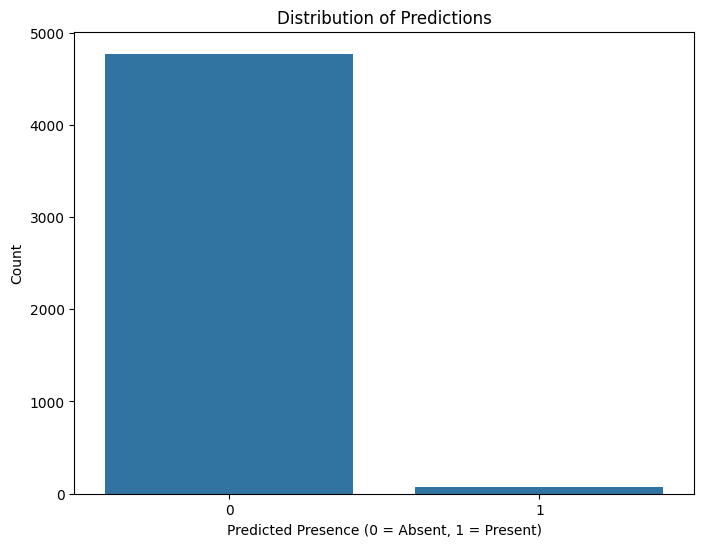

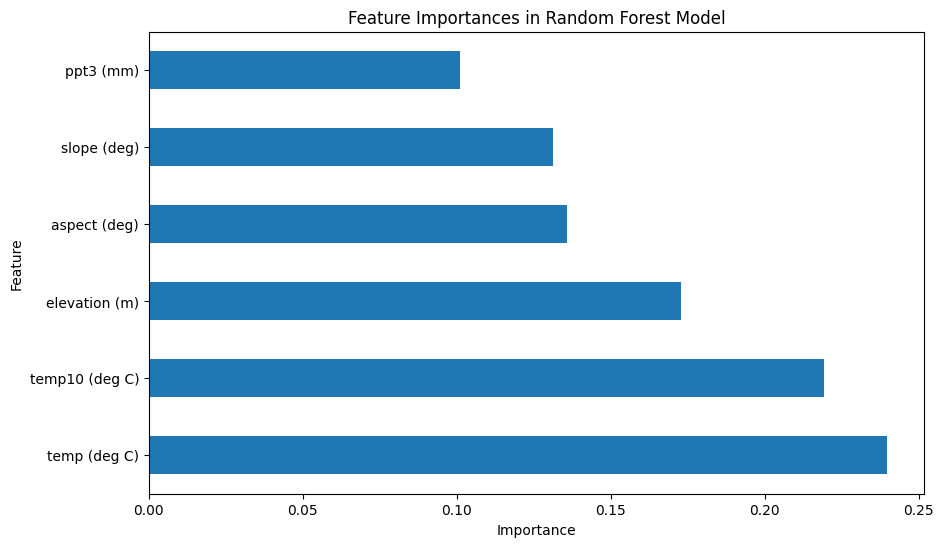

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of predictions
plt.figure(figsize=(8, 6))
sns.countplot(x=new_data_with_predictions['predicted_present'])
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Presence (0 = Absent, 1 = Present)")
plt.ylabel("Count")
plt.show()

# Get feature importances from the Random Forest model
importances = random_forest_model.feature_importances_
feature_importances = pd.Series(importances, index=feature_columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.title("Feature Importances in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
